### Proposta de Melhoria na Detecção de Minúcias em Impressões Digitais Pelo NBIS Através de Algoritmos de Visão Computacional

Embora as técnicas de representação individual continuem sendo aprimoradas, como reconhecimento de íris, voz e rosto. Reconhecimento de impressão digital ainda é um meio bastante comum no dia-a-dia, como em celulares, computadores, caixas eletrônicos, etc. Cada impressão digital é única e essa unicidade deve ser comprovada e comparada para que o acesso seja autenticado ou negado em caso de fraude, por exemplo. Os meios para que essa verificação seja feita é dada pela posição e tipo de minúcias detectadas numa impressão, nesse ambiente, quanto maior a quantidade e qualidade, melhor o resultado. Este meta-artigo propõe um método para aumentar a quantidade de minúcias detectadas pelo software NBIS através de algoritmos de visão computacional aplicadas as impressões digitais escaneadas.

In [56]:
# !/usr/bin/python

import cv2
import numpy as np
import os

import pandas as pd
import csv

import matplotlib.pyplot as plt
import seaborn as sns

import datetime

nome_pasta = "fig"
nome_pasta_saida = "output"

mindtct_path = "bin/./mindtct"
nfiq_path = "bin/./nfiq "
nfiq2_path = "bin/./nfiq2 "

lista_nome_imagens = []
lista_filtro_imagens = []
lista_numero_minucias = []

lista_nfiq_score = []
lista_nfiq2_score = []

lista_quality_map = []

#### Limpar pasta de saida
Todos os arquivos da pasta `output` serão apagados.

In [57]:
def remove_all_files_output_folder():
    for root, dirs, files in os.walk(nome_pasta_saida, topdown=False):
        for name in files:
            os.remove(os.path.join(root, name))

#### Aplicação de filtros de limiar as imagens de impressão digital
A função seguinte recebe o diretório de uma imagem e aplica cada um dos seguintes filtros salvando as alterações.

Filtros:
- Binary
- Binary Invert
- Trunc 
- Thresh to Zero
- Thresh to Zero Invert
- No Filter

A quantidade de imagens na pasta `fig` deverá ser `6n`, onde `n` é a quantidade inicial.

In [58]:
def save_many_thresholds(image_path):
    img = cv2.imread(image_path, 0)
    
    ret,thresh1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
    cv2.imwrite(image_path[:-4]+'[BINA].png',thresh1)
    
    ret,thresh2 = cv2.threshold(img,127,255,cv2.THRESH_BINARY_INV)
    cv2.imwrite(image_path[:-4]+'[BINV].png',thresh2)
    
    ret,thresh3 = cv2.threshold(img,127,255,cv2.THRESH_TRUNC)
    cv2.imwrite(image_path[:-4]+'[TRUC].png',thresh3)
    
    ret,thresh4 = cv2.threshold(img,127,255,cv2.THRESH_TOZERO)
    cv2.imwrite(image_path[:-4]+'[TZER].png',thresh4)
    
    ret,thresh5 = cv2.threshold(img,127,255,cv2.THRESH_TOZERO_INV)
    cv2.imwrite(image_path[:-4]+'[TOZI].png',thresh5)

#### NFIQ Score
Para executar, use o seguinte comando:
`nifq nome_imagem.png`
O retorno da função será a qualidade da imagem, valor discreto entre `[1-5]`.

In [59]:
def calculate_nfiq_score(image_path):
    command = str(nfiq_path+image_path)
    try:
        score = os.popen(command).readlines()[0]
    except:
        return 0
    return int(score)

#### NFIQ2 Score
Para executar, use o seguinte comando:
`nifq2 nome_imagem.png`
O retorno da função será a qualidade da imagem, valor discreto entre `[0-100]` ou `255` em caso de erro de computação.

In [60]:
def calculate_nfiq2_score(image_path):
    command = str(nfiq2_path+image_path)
    try:
        score = os.popen(command).readlines()[0]
    except:
        return 1
    return int(score)

#### Arquivo de Minúcia para Inteiro
Para cada arquivo de minúcia `.min` gerado, extrai-se apenas a informação de quantas descrições de minúcias aquele arquivo possui.

In [61]:
def min_to_minutiae_number(min_file):
    f = open(min_file)
    # use readline() to read the first line 
    line = f.readline()
    c = 1
    while line:
        line = f.readline()
        c = c + 1
        if(c == 3):
            quantidade_minucias = line
            break
    f.close()
    return int(quantidade_minucias.split()[0])

#### Quality Map

In [62]:
def minutiae_quality_map(qm_file):
    f = open(qm_file)
    line = f.readline()
    map_quality = line

    while line:
        line = f.readline()
        map_quality = map_quality + line
    f.close()
    
    str_lista_map_quality = map_quality.split(' ')
    int_lista_map_quality = []

    for i in str_lista_map_quality:
        if(str(i).isdigit()):
            int_lista_map_quality.append(int(i))

    media = sum(int_lista_map_quality) / float(len(int_lista_map_quality))
    return media

#### Aplicação de filtros de limiar as imagens de impressão digital (Batch)
Para cada imagem da pasta `fig`, cada um dos seguintes filtros serão aplicados e salvos:

In [63]:
for root, dirs, files in os.walk(nome_pasta, topdown=False):
    for name in files:
        save_many_thresholds(str(os.path.join(root, name))) 

KeyboardInterrupt: 

#### NFIQ e NFIQ2 Score (Batch)
Para cada imagem gerada, executa as funções de score do NFIQ e NFIQ2:


In [ ]:
for root, dirs, files in os.walk(nome_pasta, topdown=False):
    for name in files:
        lista_nfiq_score.append(calculate_nfiq_score(os.path.join(root, name)))
        lista_nfiq2_score.append(calculate_nfiq2_score(os.path.join(root, name)))

#### Detecção de minucias pelo NBIS
Para cada imagem gerada, executar o seguinte comando:
`mindtct -m1 nome_imagem.png output`
Após a shamada serão gerados alguns arquivos na pasta `output`, na qual, apenas o arquivo com extensão `.min` será útil nesse cenário.


In [ ]:
for root, dirs, files in os.walk(nome_pasta, topdown=False):
    for name in files:
        command = ' '.join([str(mindtct_path), '-m1', str(os.path.join(root, name)), str(os.path.join(nome_pasta_saida, name))])
        os.system(command)

#### Remoção de Arquivos que não possuem informações das minúcias
Todos os arquivos que não possuem a extensão `.min` são removidos. Aqueles que possuem, tem seus nomes de filtro e quantidade de minúcias salvas numa estrutura.

In [ ]:
for root, dirs, files in os.walk(nome_pasta_saida, topdown=False):
    for name in files:
        if name.endswith('.min'):
            #print(min_to_minutiae_number(os.path.join(root, name)))
            lista_nome_imagens.append(name)
            if('[BINA].png' in name):
                lista_filtro_imagens.append('Binary')
            elif('[BINV].png' in name):
                lista_filtro_imagens.append('Binary Invert')
            elif('[TRUC].png' in name):
                lista_filtro_imagens.append('Trunc')
            elif('[TZER].png' in name):
                lista_filtro_imagens.append('Thresh to Zero')
            elif('[TOZI].png' in name):
                lista_filtro_imagens.append('Thresh to Zero Invert')
            else:
                lista_filtro_imagens.append('No Filter')
            lista_numero_minucias.append(min_to_minutiae_number(os.path.join(root, name)))
            
        if name.endswith('.qm'):
            lista_quality_map.append(minutiae_quality_map(os.path.join(root, name)))
            
        else:
            os.remove(os.path.join(root, name))

#### Dataframe
Definição do dataframe:

- `nome` nome da imagem + [FILTRO]
- `filtro` nome do filtro ('Binary','Binary Invert','Trunc','Thresh to Zero','Thresh to Zero Invert','No Filter')
- `minucias` quantidade de minúcias detectadas pelo NBIS
- `nfiq` score gerado pelo NFIQ
- `nfiq2` score gerado pelo NFIQ2

In [ ]:
columns = ['nome','filtro','minucias','nfiq','nfiq2','qmap']

df = pd.DataFrame(columns=columns)

df['nome'] = lista_nome_imagens
df['filtro'] = lista_filtro_imagens
df['minucias'] = lista_numero_minucias
df['nfiq'] = lista_nfiq_score
df['nfiq2'] = lista_nfiq2_score
df['qmap'] = lista_quality_map

#### Manipulação de Dados (NBIS)
Agrupamento por nome do filtro e quantidade total de minucias.

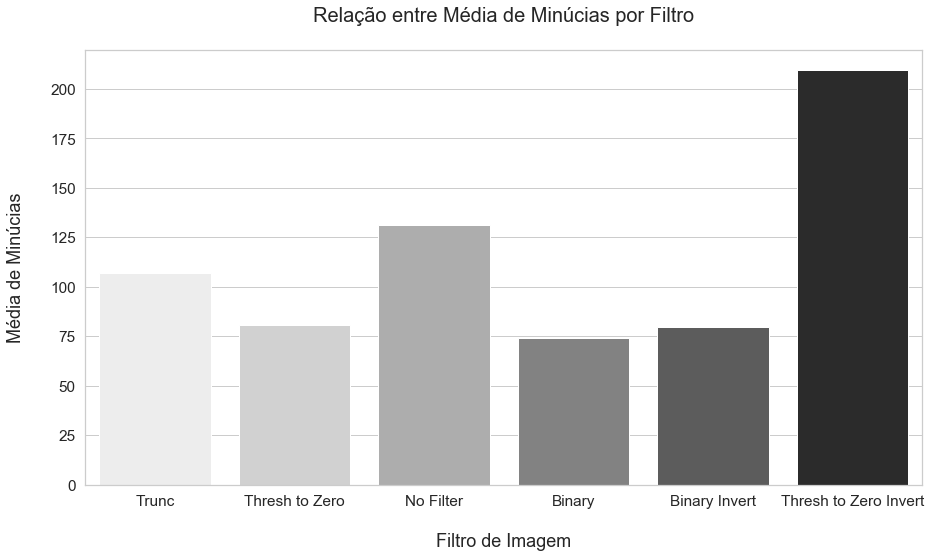

In [68]:
import pandas as pd
import csv

import matplotlib.pyplot as plt
import seaborn as sns

df.to_csv('data_frame.csv')

df.shape

df.groupby(['filtro', 'nome'], as_index=True).mean().groupby('filtro')['minucias'].mean()

plt.figure(figsize=(15,8))
sns.set(font_scale=1.4)
sns.set_style('whitegrid')
sns.barplot('filtro', 'minucias', data=df, ci=0, palette="Greys")

plt.title('Relação entre Média de Minúcias por Filtro\n', fontsize=20)
plt.ylabel('Média de Minúcias\n', fontsize=18)
plt.xlabel('\nFiltro de Imagem', fontsize=18)
        
plt.savefig("filtro_qt_minucias.pdf", bbox_inches='tight')
plt.show()

#### Manipulação de Dados (NFIQ)
Agrupamento por nome do filtro e média do NFIQ Score.

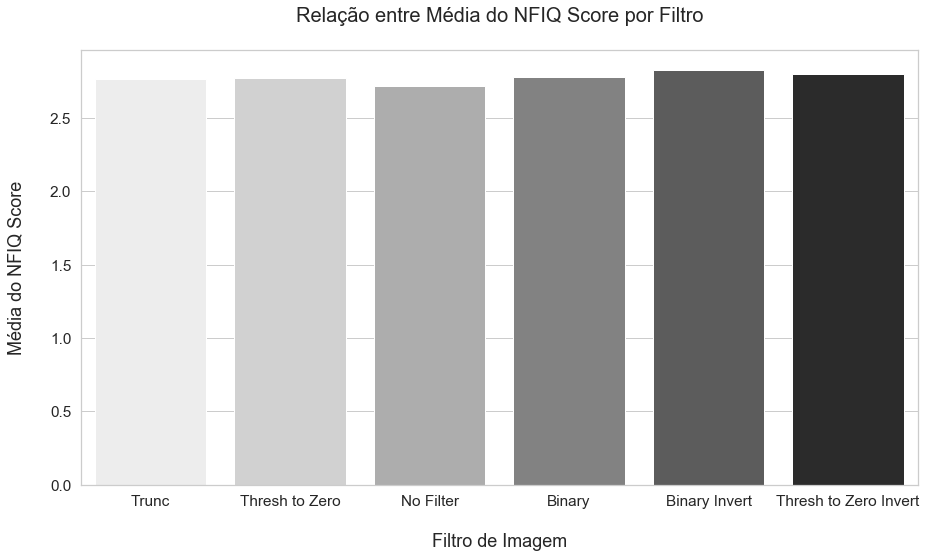

In [69]:
import pandas as pd
import csv

import matplotlib.pyplot as plt
import seaborn as sns

df.to_csv('data_frame.csv')

df.shape

df.groupby(['filtro', 'nome'], as_index=True).mean().groupby('filtro')['nfiq'].mean()

plt.figure(figsize=(15,8))
sns.set(font_scale=1.4)
sns.set_style('whitegrid')
sns.barplot('filtro', 'nfiq', data=df, ci=0, palette="Greys")

plt.title('Relação entre Média do NFIQ Score por Filtro\n', fontsize=20)
plt.ylabel('Média do NFIQ Score\n', fontsize=18)
plt.xlabel('\nFiltro de Imagem', fontsize=18)

plt.savefig("filtro_nfiq_score.pdf", bbox_inches='tight')
plt.show()

#### Manipulação de Dados (NFIQ2)
Agrupamento por nome do filtro e média do NFIQ2 Score.

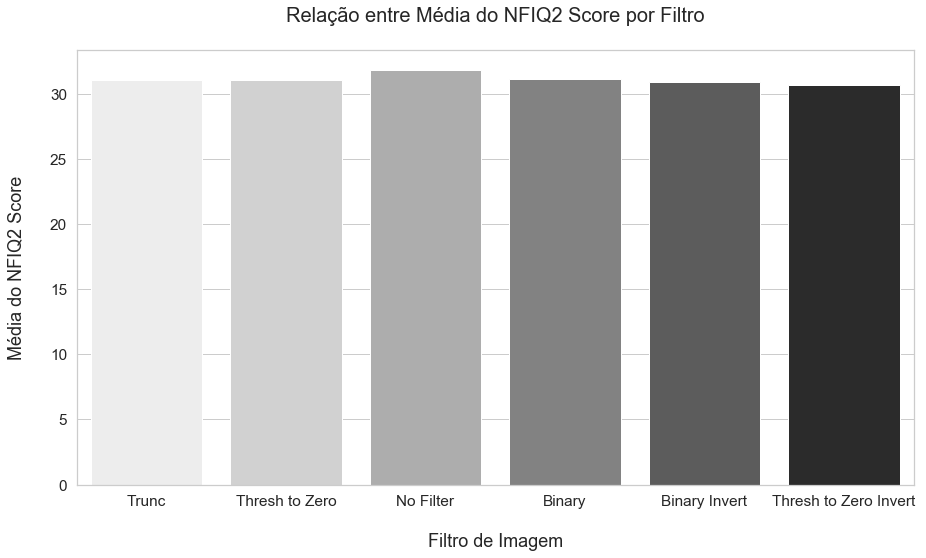

In [70]:
import pandas as pd
import csv

import matplotlib.pyplot as plt
import seaborn as sns

df.to_csv('data_frame.csv')

df.shape

df.groupby(['filtro', 'nome'], as_index=True).mean().groupby('filtro')['nfiq2'].mean()

plt.figure(figsize=(15,8))
sns.set(font_scale=1.4)
sns.set_style('whitegrid')
g = sns.barplot('filtro', 'nfiq2', data=df, ci=0, palette="Greys")

plt.title('Relação entre Média do NFIQ2 Score por Filtro\n', fontsize=20)
plt.ylabel('Média do NFIQ2 Score\n', fontsize=18)
plt.xlabel('\nFiltro de Imagem', fontsize=18)

plt.savefig("filtro_nfiq2_score.pdf", bbox_inches='tight')    
plt.show()

#### Manipulação de Dados (Quality Map)
Agrupamento por nome do filtro e média do Quality Map.

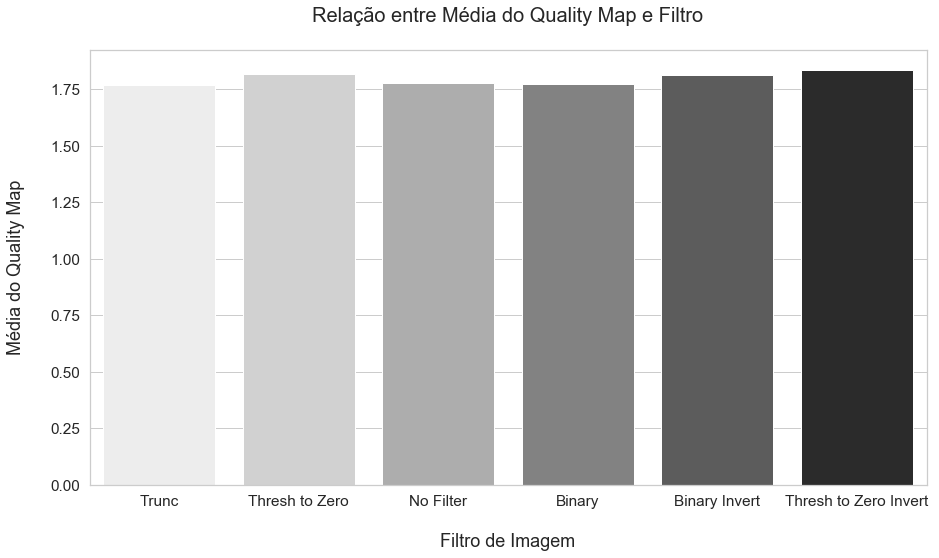

In [71]:
import pandas as pd
import csv

import matplotlib.pyplot as plt
import seaborn as sns

df.to_csv('data_frame.csv')

df.shape

df.groupby(['filtro', 'nome'], as_index=True).mean().groupby('filtro')['qmap'].mean()

plt.figure(figsize=(15,8))
sns.set(font_scale=1.4)
sns.set_style('whitegrid')
g = sns.barplot('filtro', 'qmap', data=df, ci=0, palette="Greys")

plt.title('Relação entre Média do Quality Map e Filtro\n', fontsize=20)
plt.ylabel('Média do Quality Map\n', fontsize=18)
plt.xlabel('\nFiltro de Imagem', fontsize=18)

plt.savefig("filtro_qmap.pdf", bbox_inches='tight')    
plt.show()